## Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                              accuracy_score, roc_auc_score, roc_curve)
from sklearn.pipeline import Pipeline

In [3]:
# import dataset

file_path = '/content/amazon_user_reviews_regular_ML_simplified_3_cat.parquet'
import pandas as pd
df = pd.read_parquet(file_path)

df.info()
# based on rsult of feature selection:
## keep one from word_count, char_count, total_punctuatuation, (*verified_purchase)
## keep one from season and month

# choose word_count, verified_purchase, month
features = ['exclamation_count', 'question_count', 'word_count',
       'all_caps_words', 'uppercase_ratio',
       'avg_word_length', 'helpful_vote', 'int_verified_purchase', 'hour',
       'month']

X = df[features]
y = df["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18400 entries, 0 to 18399
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sentiment              18400 non-null  int64  
 1   exclamation_count      18400 non-null  int64  
 2   question_count         18400 non-null  int64  
 3   word_count             18400 non-null  int64  
 4   char_count             18400 non-null  int64  
 5   all_caps_words         18400 non-null  int64  
 6   uppercase_ratio        18400 non-null  float64
 7   total_punctuation      18400 non-null  int64  
 8   avg_word_length        18400 non-null  float64
 9   helpful_vote           18400 non-null  int64  
 10  int_verified_purchase  18400 non-null  int64  
 11  hour                   18400 non-null  int32  
 12  month                  18400 non-null  int32  
 13  season                 18400 non-null  int64  
dtypes: float64(2), int32(2), int64(10)
memory usage: 1.8 M

In [6]:
# scalar and fit logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=1.0, max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)

# predict
y_pred      = pipeline.predict(X_test)
y_prob      = pipeline.predict_proba(X_test)

# evaluation
# reference: https://www.geeksforgeeks.org/machine-learning/auc-roc-curve/

print(classification_report(y_test, y_pred))

print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro'):.4f}")

              precision    recall  f1-score   support

           0       0.48      0.34      0.40      1236
           1       0.45      0.44      0.44      1217
           2       0.37      0.49      0.42      1227

    accuracy                           0.42      3680
   macro avg       0.43      0.42      0.42      3680
weighted avg       0.43      0.42      0.42      3680

Accuracy : 0.4201
ROC-AUC  : 0.5996


In [7]:
# cross validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-Validation Accuracy: 0.4162 ± 0.0163


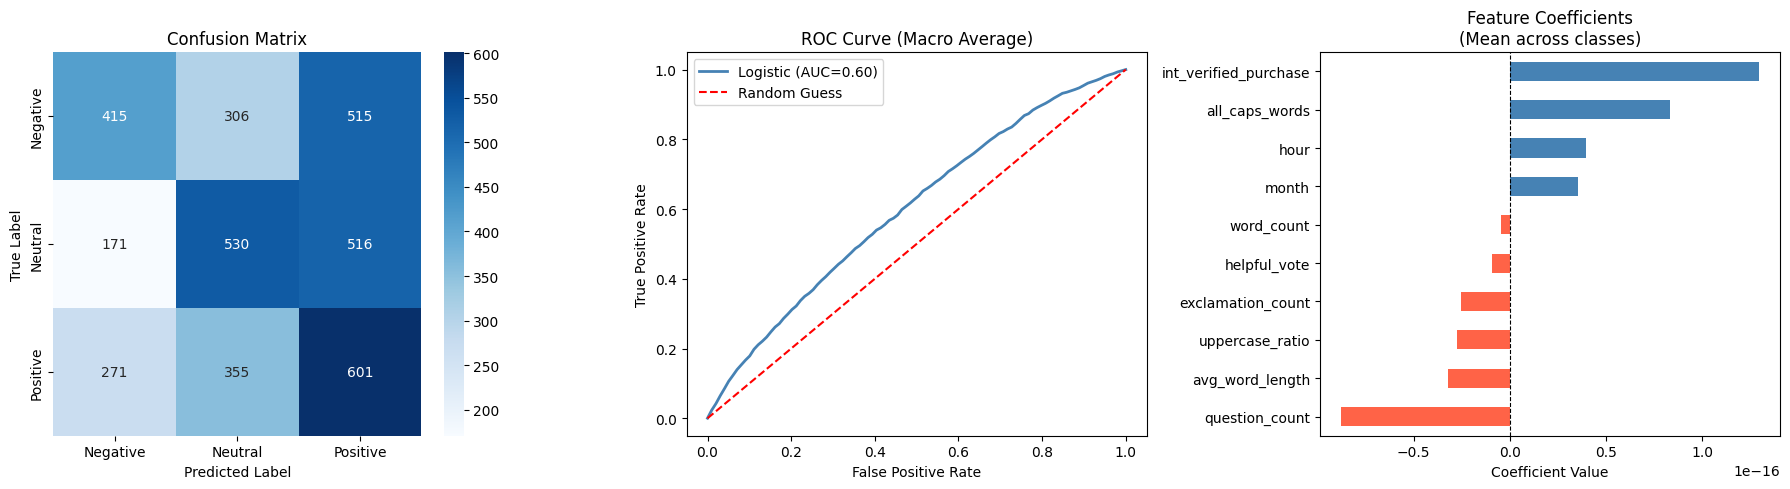

In [12]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

classes     = [0, 1, 2]
class_names = ['Negative', 'Neutral', 'Positive']

# Build test_df from your trained pipelines
test_df = pd.DataFrame({
    'True'        : y_test.values,
    'Logistic'    : list(pipeline.predict_proba(X_test)),
    # 'RandomForest': list(rf_pipeline.predict_proba(X_test))   # add when ready
})

y_pred     = pipeline.predict(X_test)
y_test_bin = label_binarize(test_df['True'], classes=classes)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
cm = confusion_matrix(test_df['True'], y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[0]
)
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

#ROC Curve
model_styles = {'Logistic': 'steelblue'}
# add 'RandomForest': 'darkorange' once have that model

for model, color in model_styles.items():
    y_prob  = np.array(test_df[model].tolist())   # shape: (n_samples, 3)
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([
        np.interp(mean_fpr, *roc_curve(y_test_bin[:, i], y_prob[:, i])[:2])
        for i in range(len(classes))
    ], axis=0)
    macro_auc = auc(mean_fpr, mean_tpr)
    axes[1].plot(mean_fpr, mean_tpr, color=color, lw=2,
                 label=f'{model} (AUC={macro_auc:.2f})')

axes[1].plot([0, 1], [0, 1], 'r--', label='Random Guess')
axes[1].set_title('ROC Curve (Macro Average)')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()

#Feature Coefficients
coef       = pipeline.named_steps['lr'].coef_   # shape: (3, n_features)
coef_mean  = coef.mean(axis=0)                  # average across 3 classes
coef_series = pd.Series(coef_mean, index=features).sort_values()
bar_colors  = ['tomato' if c < 0 else 'steelblue' for c in coef_series]

coef_series.plot(kind='barh', color=bar_colors, ax=axes[2])
axes[2].axvline(x=0, color='black', linewidth=0.8, linestyle='--')
axes[2].set_title('Feature Coefficients\n(Mean across classes)')
axes[2].set_xlabel('Coefficient Value')

plt.tight_layout()
plt.savefig('logistic_regression_results.png', dpi=150, bbox_inches='tight')
plt.show()

## Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB

In [15]:
nb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nb', GaussianNB())
])

# train
nb_pipeline.fit(X_train, y_train)

# predict
y_pred = nb_pipeline.predict(X_test)
y_prob = nb_pipeline.predict_proba(X_test)   # shape: (n_samples, 3)

# evaluate
print(classification_report(y_test, y_pred,
      target_names=['Negative', 'Neutral', 'Positive']))

print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro'):.4f}")

# 5-fold cross validation
cv_scores = cross_val_score(nb_pipeline, X, y, cv=5, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

              precision    recall  f1-score   support

    Negative       0.35      0.91      0.50      1236
     Neutral       0.41      0.09      0.14      1217
    Positive       0.43      0.07      0.12      1227

    accuracy                           0.36      3680
   macro avg       0.40      0.35      0.26      3680
weighted avg       0.40      0.36      0.26      3680

Accuracy : 0.3571
ROC-AUC  : 0.5881
CV Accuracy: 0.3617 ± 0.0064


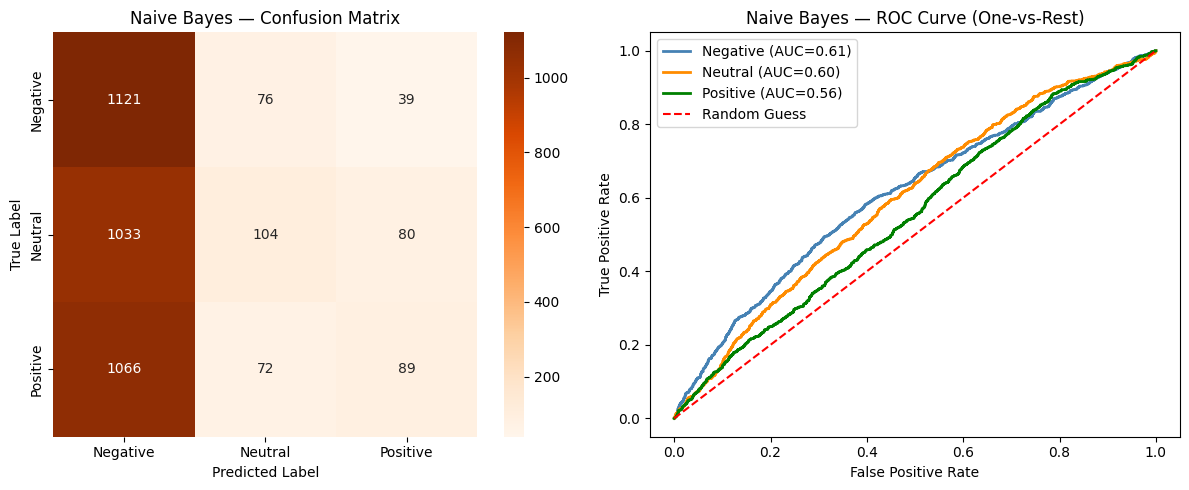

In [17]:
classes     = [0, 1, 2]
class_names = ['Negative', 'Neutral', 'Positive']
y_test_bin  = label_binarize(y_test, classes=classes)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[0]
)
axes[0].set_title('Naive Bayes — Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

colors = ['steelblue', 'darkorange', 'green']
for i, (cls_name, color) in enumerate(zip(class_names, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color=color, lw=2,
                 label=f'{cls_name} (AUC={roc_auc:.2f})')

axes[1].plot([0, 1], [0, 1], 'r--', label='Random Guess')
axes[1].set_title('Naive Bayes — ROC Curve (One-vs-Rest)')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()

plt.tight_layout()
plt.savefig('naive_bayes_results.png', dpi=150, bbox_inches='tight')
plt.show()